In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# corchete signado
def csign(x, alpha):
    return np.sign(x) * np.abs(x)**alpha

In [3]:
# Generador de referencia con derivadas
def ref_signal(w, y0, Ts):
    t = 0
    while True:
        ref = y0 * np.sin(w*t)
        ref_dot = y0 * w * np.cos(w*t)
        ref_ddot = -y0 * w**2 * np.sin(w*t)
        yield ref, ref_dot, ref_ddot
        t += Ts

In [13]:
def observer(Ts, e1_hat0=0, e2_hat0=0, aN=0.001, k1=23.4, k2=31.6, k3=20, l1=2, l2=1.1, lam=20):
    e1_hat = e1_hat0
    e2_hat = e2_hat0
    
    while True:
        e1 = yield (e1_hat, e2_hat) # recibe e1, entrega e1_hat y e2_hat
        
        # Ecuaciones del observador
        e1_err = e1_hat - e1
        e1_hat_dot = -lam*l1 * csign(e1_err, 2/3) + e2_hat

        e2_aux = e1 + k2*csign(e2_hat,3/2)
        e2_hat_dot = -l2*(lam**2) * csign(e1_err, 1/3) - k1*aN*csign(e2_aux, 1/3)
        
        # Integración (Euler)
        e1_hat += Ts * e1_hat_dot
        e2_hat += Ts * e2_hat_dot

In [14]:
def controller(Ts, sigma0=0, k1=23.4, k2=31.6, k3=20):
    sigma = sigma0
    
    while True:
        e1, e2_hat = yield u if 'u' in locals() else 0 # recibe e1 y e2_hat, entrega u
        
        # Señal de control
        uaux = e1 + k2*csign(e2_hat, 3/2)
        u = -k1*csign(uaux, 1/3) - k3*sigma
        
        # Integración de sigma (Euler)
        sigma_dot = np.sign(e1)
        sigma += Ts*sigma_dot  

In [40]:
def plant_dynamics(Ts, th1=3, th2=1, x1_0=0, x2_0=0):
    x1, x2 = x1_0, x2_0

    while True:
        u, ref, ref_dot, ref_ddot = yield (x1, x2) # recibe u, entrega x1 y x2

        # sistema en Mor20
        x1_dot = x2
        x2_dot = -th1*np.sin(x1) + th2*u

        # sistema en Bes00
        # m_q = 1+(np.cos(x1)**2)
        # c_q = -0.5*np.sin(2*x1)
        # g_q = 9.81*np.sin(x1)
        
        # x1_dot = x2
        # x2_dot = (1/m_q)*(u - g_q - c_q*(x2**2))

        # # Integración (Euler)
        x1 += Ts*x1_dot
        x2 += Ts*x2_dot

In [62]:
# ------------------- Inicialización del Experimento -------------------

# Parámetros del experimento
Ts = 3e-5
tfinal = 15.0
steps = int(tfinal / Ts)
w = 2
y0 = 0.5
x1_0 = 0.5
x2_0 = 0.5

# Inicializar generadores
ref_gen = ref_signal(w=w, y0=y0, Ts=Ts)
obs = observer(Ts)
ctrl = controller(Ts)
plant = plant_dynamics(Ts, x1_0=x1_0, x2_0=x2_0)

# Inicializar
ref, ref_dot, ref_ddot = next(ref_gen)
e1_hat, e2_hat = next(obs)  
u = next(ctrl)
x1, x2 = next(plant)

# Arrays para guardar datos
t_data = []
ref_data = []
x1_data = []
e1_data = []
u_data = []
e2_obs_data = []
e2_real_data = [] 
e2_err_data = [] 

In [63]:
# Loop principal
for i in tqdm(range(steps)):
    # Obtener referencia
    ref, ref_dot, ref_ddot = next(ref_gen)
    
    # Calcular error
    e1 = x1 - ref
    e2 = x2 - ref_dot
    
    # Observador
    e1_hat, e2_hat = obs.send(e1)
    
    # Controlador
    u = ctrl.send((e1, e2_hat))
    u += ref_ddot
    
    # Planta
    x1, x2 = plant.send((u, ref, ref_dot, ref_ddot))
    
    # Guardar datos 
    t_data.append(i * Ts)
    ref_data.append(ref)
    x1_data.append(x1)
    e1_data.append(e1)
    u_data.append(u)
    #e2_obs_data.append(e2_hat)
    #e2_real_data.append(e2)
    #e2_err_data.append(e2_hat - e2)

100%|██████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [00:05<00:00, 94677.88it/s]


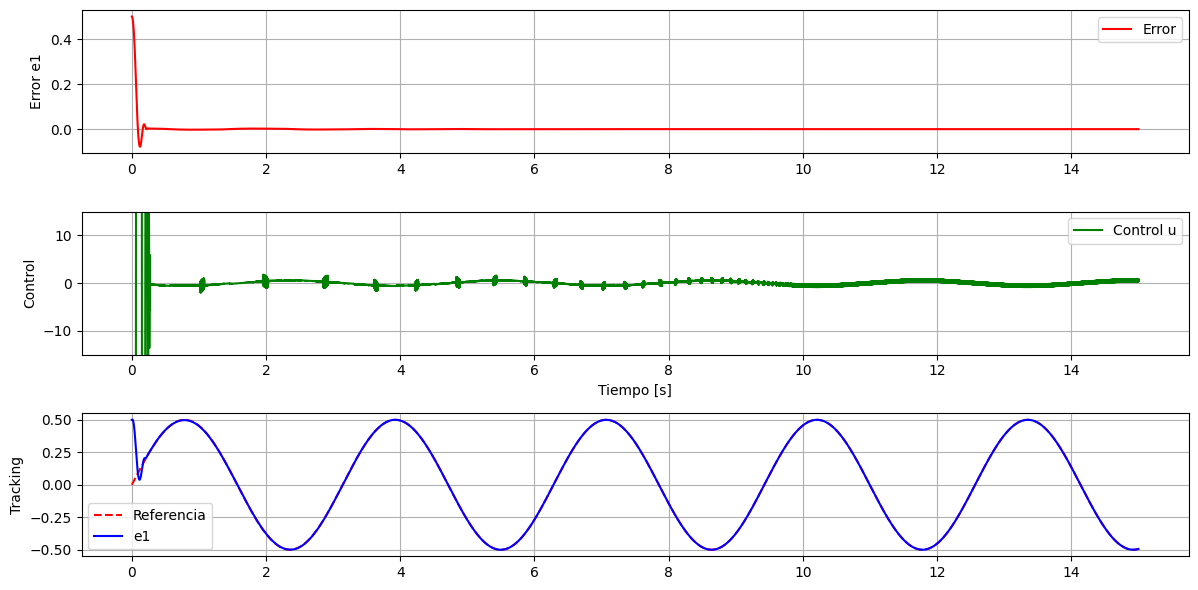

In [64]:
# Graficar resultados
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t_data, e1_data, 'r', label='Error')
plt.ylabel('Error e1')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_data, u_data, 'g-', label='Control u')
plt.xlabel('Tiempo [s]')
plt.ylabel('Control')
plt.ylim(-15, 15)
plt.legend()
plt.grid(True)


plt.subplot(3, 1, 3)
plt.plot(t_data, ref_data, 'r--', label='Referencia')
plt.plot(t_data, x1_data, 'b', label='e1')
plt.ylabel('Tracking')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()